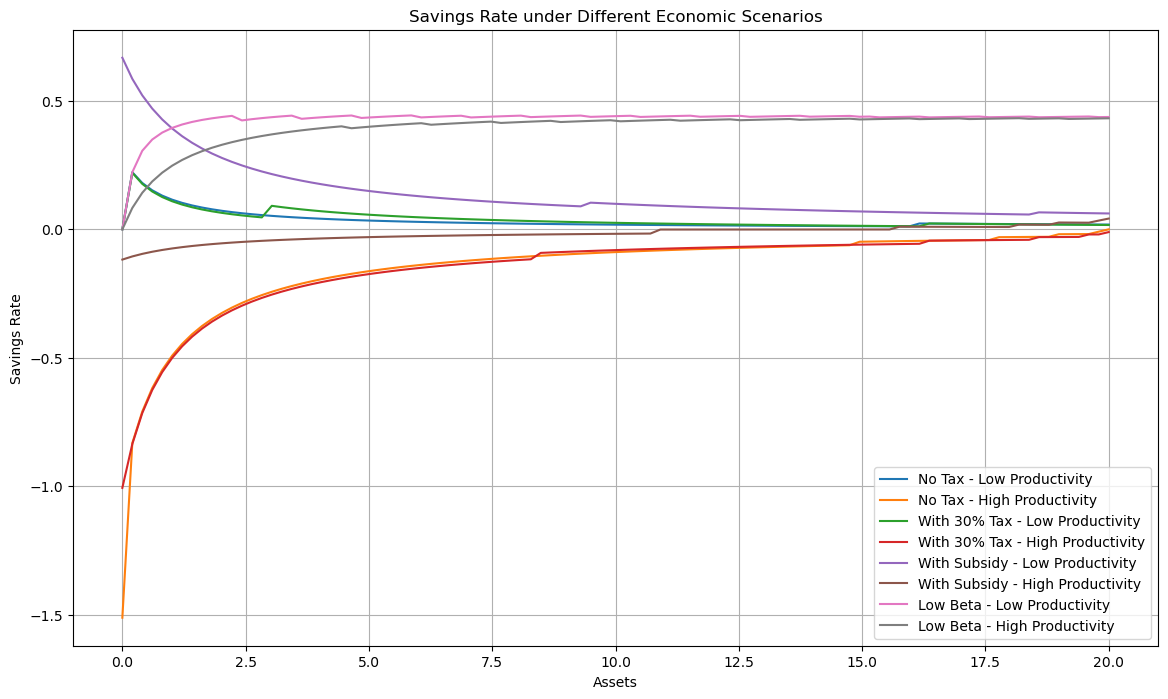

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定
sigma = 1.5
beta = 0.98  # 標準の時間選好率
r = 0.04
w = 1
a_min = 0
a_max = 20
NA = 100
a_grid = np.linspace(a_min, a_max, NA)

# 生産性の状態
h = np.array([np.exp(-0.7), np.exp(0.7)])  # Low and high productivity states
pi = np.array([[0.875, 0.125], [0.125, 0.875]])  # Transition probabilities

# 消費関数
def utility(c, sigma):
    return (c**(1 - sigma)) / (1 - sigma) if sigma != 1 else np.log(c)

# 家計の問題を解く関数
def solve_household(beta, r, w, h, pi, a_grid, tax_rate=0, subsidy=0):
    NA = len(a_grid)
    NH = len(h)
    V = np.zeros((NA, NH))
    policy = np.zeros((NA, NH))
    c_policy = np.zeros((NA, NH))
    
    for _ in range(1000):
        V_new = np.zeros_like(V)
        for ia, a in enumerate(a_grid):
            for ih, h_val in enumerate(h):
                # 保有資産から新しい資産への移行を考える
                c = w * h_val + (1 + (1 - tax_rate) * r) * a - a_grid + subsidy
                c = np.maximum(c, 1e-5)  # 負の消費を防ぐ
                util = utility(c, sigma)
                
                # Vの次元を適切に扱う
                expected_V = pi[ih, :] @ V.T  # 正しい行列乗算
                max_utility = util + beta * expected_V
                max_index = np.argmax(max_utility)
                
                V_new[ia, ih] = max_utility[max_index]
                policy[ia, ih] = a_grid[max_index]
                c_policy[ia, ih] = c[max_index]
        
        if np.max(np.abs(V - V_new)) < 1e-6:
            break
        V = V_new
    
    return policy, c_policy


# シナリオごとにポリシーを計算
_, c_policy_base = solve_household(beta, r, w, h, pi, a_grid)
_, c_policy_tax = solve_household(beta, r, w, h, pi, a_grid, tax_rate=0.3)
_, c_policy_subsidy = solve_household(beta, r, w, h, pi, a_grid, subsidy=1)
_, c_policy_low_beta = solve_household(0.1, r, w, h, pi, a_grid)

# 貯蓄率を計算
def savings_rate(a_grid, c_policy):
    savings = a_grid[:, None] + c_policy - w * h[None, :] - (1 + r) * a_grid[:, None]
    savings_rate = savings / (a_grid[:, None] + c_policy)
    return savings_rate

# グラフをプロット
plt.figure(figsize=(14, 8))
for scenario, c_policy, label in zip(["Base", "Tax", "Subsidy", "Low Beta"],
                                     [c_policy_base, c_policy_tax, c_policy_subsidy, c_policy_low_beta],
                                     ["No Tax", "With 30% Tax", "With Subsidy", "Low Beta"]):
    sr = savings_rate(a_grid, c_policy)
    plt.plot(a_grid, sr[:, 0], label=f'{label} - Low Productivity')
    plt.plot(a_grid, sr[:, 1], label=f'{label} - High Productivity')

plt.title("Savings Rate under Different Economic Scenarios")
plt.xlabel("Assets")
plt.ylabel("Savings Rate")
plt.legend()
plt.grid(True)
plt.show()

